In [99]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split

## Open MNIST data and create a subset with desired digits

<font color=red>Change the code below to select a different subset </font>

In [100]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([X, y], handle)


In [101]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    X, y = pickle.load(handle)

X = X
    
Nclasses = 10
labelclasses = y<Nclasses
Xnew = X[labelclasses]
ynew = y[labelclasses]
Nfeatures = np.size(Xnew,1)
Nsamples = np.size(Xnew,0)


In [102]:
 
X_train, X_test, y_train, y_test = train_test_split(Xnew, ynew, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.14, random_state=1) # 0.25 x 0.8 = 0.2

Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]

X_train = X_train.T
X_val = X_val.T
X_test = X_test.T


### The Cell Below Contains Basic Utilities Shared Between Steps

In [103]:
def getClassRange(y_data):
    """get class range

    Given a series of class values, since our classes map directly to index values
    (0, 1, 2, 3) we take the max and min value of the series to determine what classes
    are included in our data.
    """
    return range(np.min(y_data), np.max(y_data)+1)

def testLinearMCClassifier(A, x_test, y_expect, output = False):
    """Test linear multi-class classifier

    Given a A matrix, test x and y, compare the expected y with predicted y calculated
    by taking A[class#] * x_test. This produces the discriminant for each class. Any negative
    values detected for a given classes predicted discriminant line are a misclassification.

    Parameters
    ----------
    A
        The matrix A with columns representing a classes 'a' matrix.
    x_test
        X test data used for verification via producing X_tilde
    y_expect
        Expected y values for associated x data
    output
        Whether to print the generic misclassification report

    Returns
    -------
    Int
        Number of misclassifications
    """
    misclassifications = 0
    total = y_expect.size

    x_tilde = np.vstack((x_test, np.ones(len(x_test[0]))))
    y_predict = [] #index represents class predictions

    for i in getClassRange(y_expect):
        a_i = A[i]
        y_predict.append(np.matmul(a_i.T, x_tilde))

    for i, expect_y in enumerate(y_expect):
        y_i = y_predict[expect_y]
        if y_i[i] <= 0:
            misclassifications += 1

    if output:
        print(f"Mis-classifications = {misclassifications} out of {total} equivalent to {(misclassifications / total)*100} %")

    return misclassifications

def graphClassifier(A):
    """Graph classifier

    Taking the A matrix, produces a 3x3 plot grid of imshow of A[0-8]

    Parameters
    ----------
    A
        The matrix A with columns representing a classe's 'a_i' matrix.

    Returns
    -------
    fig, axs
        Matplotlib graphing objects
    """
    fig, axs = plt.subplots(3, 3)
    ref = 0
    for i in range(0, 3):
        for j in range(0, 3):
            axs[i, j].set_title(ref)
            axs[i, j].imshow(np.reshape(A[ref][0:784],(28,28)))
            ref += 1
    
    return fig, axs


## Classifiers:

### Guassian Multi-Channel Classifier:

In [104]:
def gaussianMultiChannelClassifier(x_data, y_data): # Phase2 - step 2
    """gaussian multi channel classifier

    The following computes the multi-channel gaussian classifier with the
    identity covariance.

    Examples
    --------
    >>> gaussianMultiChannelClassifier(X_train, y_train)

    Parameters
    ----------
    x_data
        The input data set values
    y_data
        The associated class for each sample

    Returns
    -------
    np.array
        A (n x weights) array representing the a_i for a given class in each column
        a_i is used to compute discriminant with a_i * x_tilde
    """
    i_cov = np.identity(len(x_data)) #Identity covariance matrix, reused for each class
    inv_i_cov = np.linalg.inv(i_cov)
    result_a = []

    for class_i in getClassRange(y_data):
        class_i_indices = (y_data == class_i)
        x_i = x_data.T[class_i_indices]
        u_i = np.mean(x_i, axis=0)
    
        W_i = 2*np.matmul(inv_i_cov, u_i)
        const_w_i = np.matmul(u_i.T, np.matmul(inv_i_cov, u_i))

        a_i = np.hstack((W_i.T, -const_w_i))
        result_a.append(a_i)

    result_a = np.array(result_a)
    return result_a


### Logistic Regression Multi-Class Classifier

In [105]:
def logisticRegressionMultiClassClassifier(x_data, y_data, iterations=100, step_size=1e-4):
    """logistic regression multiclass classifier

    The following computes the logistic regression multiclass classifier and returns the A matrix

    Parameters
    ----------
    x_data
        The input data set values
    y_data
        The associated class for each sample
    iterations
        Number of iterations performed
    step_size
        Declared step size each iteration

    Returns
    -------
    np.array
        A (n x weights) array representing the a_i for a given class in each column
        a_i is used to compute discriminant with a_i * x_tilde
    """
    A = np.random.randn(len(x_data)+1, np.max(y_data)+1)
    x_tilde = np.vstack((x_data, np.ones(len(x_data[0]))))

    # Translate y_data to new array where column represents class, and column has 0's for not that class, and 1's for that class
    y_new = []
    for i in getClassRange(y_data):
        y_i = (y_data == i)
        y_new.append(y_i)
    
    y_new = np.array(y_new)
        
    for iter in range(iterations):
        s = expit(np.matmul(A.T, x_tilde))
        error = s-y_new
        gradient = -np.matmul(x_tilde, error.T)
        A = A + step_size*gradient

    return A.T


### Logistic Regression Multi-Class Classifier with Regularization

In [106]:
def logisticRegressionMultiClassClassifierWithRegularization(x_data,y_data,iterations=100,step_size=1e-4,lam=0):
    """logistic regression multiclass classifier with regularization

    The following computes the logistic regression multiclass classifier WITH regularization (lambda)
    and returns the A matrix

    Parameters
    ----------
    x_data
        The input data set values
    y_data
        The associated class for each sample
    iterations
        Number of iterations performed
    step_size
        Declared step size each iteration
    lam
        Regularization value (offset lambda)

    Returns
    -------
    np.array
        A (n x weights) array representing the a_i for a given class in each column
        a_i is used to compute discriminant with a_i * x_tilde
    """
    A = np.random.randn(len(x_data)+1, np.max(y_data)+1)
    x_tilde = np.vstack((x_data, np.ones(len(x_data[0]))))

    # Translate y_data to new array where column represents class, and column has 0's for not that class, and 1's for that class
    y_new = []
    for i in getClassRange(y_data):
        y_i = (y_data == i)
        y_new.append(y_i)
    
    y_new = np.array(y_new)

    for iter in range(iterations):
        s = expit(np.matmul(A.T, x_tilde))
        error = s-y_new
        gradient = -(np.matmul(x_tilde, error.T) + (2 * lam * A))
        A = A + step_size*gradient

    return A.T

def Optimize_MC_Hyperparameters(x_data ,y_data, range):
    """Optimize logistic multiclass regularization parameter

    The following computes the logistic regression multiclass classifier WITH regularization for each
    lambda value in range, returning the A matrix that had the lowest misclassification on the input
    dataset.

    Parameters
    ----------
    x_data
        The input data set values
    y_data
        The associated class for each sample
    range
        Some form of iterable for lambda values to test

    Returns
    -------
    np.array
        A (n x weights) array representing the a_i for a given class in each column
        a_i is used to compute discriminant with a_i * x_tilde
    """
    best_A = None
    best_misclassifications = None
    best_lambda = None

    for lam in range:
        A = logisticRegressionMultiClassClassifierWithRegularization(x_data, y_data, 1000, lam=lam)
        misclassifications = testLinearMCClassifier(A, x_data, y_data)

        if best_misclassifications == None or misclassifications < best_misclassifications:
            best_misclassifications = misclassifications
            best_A = A
            best_lambda = lam

    print(f"Best lambda: {best_lambda}")
    return best_A


## Testing Classifier Performance
### Guassian Performance

In [108]:
print("Guassian Classifier Performance:")
A = gaussianMultiChannelClassifier(X_train, y_train)
result = testLinearMCClassifier(A, X_test, y_test, True)
fig, axs = graphClassifier(A)

Guassian Classifier Performance:
Mis-classifications = 91 out of 6531 equivalent to 1.3933547695605575 %


### Logistic Regression Performance

Mis-classifications = 104 out of 6531 equivalent to 1.5924054509263512 %


IndexError: index 3 is out of bounds for axis 0 with size 3

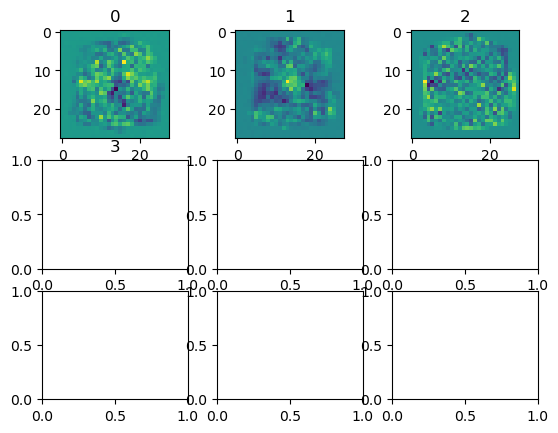

In [127]:

A = logisticRegressionMultiClassClassifier(X_train, y_train, 10000)
result = testLinearMCClassifier(A, X_test, y_test, True)
fig, axs = graphClassifier(A)


### Optimized Logistic Regression with Regularization Performance

In [125]:
A = Optimize_MC_Hyperparameters(X_train, y_train, np.linspace(10, 15, 6))
result = testLinearMCClassifier(A, X_test, y_test, True)
fig, axs = graphClassifier(A)

Best lambda: 12.0
Mis-classifications = 117 out of 6531 equivalent to 1.7914561322921452 %


# Performance Reflections